In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from IPython.display import display
import warnings
warnings.filterwarnings(action="ignore")
from IPython.display import display
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 클러스터링을 위한 전처리

In [ ]:
data = pd.read_pickle('/content/drive/Shareddrives/빅콘테스트/클러스터링을위한merged_df')

## credit score

In [ ]:
# credit에 쓸 col들만 credit_needed에 정리
credit_needed = data[['user_id', 'credit_score', 'loanapply_insert_time']]
# credit 존재하는 애들만 보기 위해 credit_notnull
credit_notnull = credit_needed.dropna()
credit_date = credit_notnull.groupby('user_id')['loanapply_insert_time'].max().reset_index()
credit_merged = pd.merge(credit_date, credit_notnull, how='left').drop_duplicates()
credit = credit_merged['credit_score']
credit_mode = credit.mode()
credit_all = pd.merge(data[['user_id']].dropna(), credit_merged[['user_id', 'credit_score']], how='left').drop_duplicates()
credit_all = credit_all.fillna(610)
credit_all.head()

,user_id,credit_score
0,430982.0,620.0
1,518638.0,620.0
2,82404.0,630.0
4,253902.0,740.0
5,27904.0,900.0


## yearly_income

In [ ]:
income = data.groupby('user_id')['loanapply_insert_time'].max().reset_index()
income_merged = pd.merge(income, data, how = 'left')[['user_id', 'yearly_income']].drop_duplicates()

# 이외 칼럼

- 기대출 과다자: 모델링 데이터 전처리 칼럼의 excess_of_existing_loan과 동일

- UseDSRCalc, UseLoanManage, UsePrepayCalc: 동명의 로그 데이터 전처리 칼럼과 동일

# kmeans 클러스터링 함수

In [ ]:
# 클러스터링에 사용될 데이터 스케일링을 위한 함수
def scaling (data):
  data = data.set_index('user_id')
  scaled = StandardScaler().fit_transform(data)
  scaled = pd.DataFrame(scaled, columns = data.columns)
  scaled = scaled.set_index(data.index)
  return scaled

In [ ]:
# 유저 별로 군집과 실루엣 계수 칼럼이 추가된 데이터프레임, centroid, 평균 실루엣 값, 군집별 실루엣 값을 리턴해주는 함수
def clustering(data, cluster_num):
  model = KMeans(n_clusters=cluster_num, random_state=312, algorithm='auto')
  model.fit(data)
  pred = model.predict(data)
  centroids = model.cluster_centers_
  centroids = pd.DataFrame(centroids, columns = data.columns)
  data['k_means_cluster'] = pred
  data['k_silhouette_coeff'] = silhouette_samples(data, data['k_means_cluster'])
  k_average_score = silhouette_score(data, data['k_means_cluster'])
  each_silhouette = data.groupby('k_means_cluster')['k_silhouette_coeff'].mean()
  print(each_silhouette)
  print('Average Silhouette Score:{0:.3f}'.format(k_average_score))
  return data, centroids, k_average_score, each_silhouette

In [ ]:
# 군집별 그래프를 그리기 위한 함수
def display_parallel_coordinates_centroids(df, num_clusters):
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)
    parallel_coordinates(df, 'cluster', color=palette)
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)  

def set_centroid(centroid_data):
  centroids = centroid_data
  centroids['cluster'] = centroids.index
  return centroids

## applied1 - 핀다 이용 양상

In [ ]:
data = pd.read_pickle('/content/drive/Shareddrives/빅콘테스트/0_최종코드/클러스터링/applied1_droped')
action = data[['user_id','UseDSRCalc', 'UseLoanManage', 'UsePrepayCalc']]
action = action.set_index('user_id')
scaled_action = action.apply(lambda x: np.log(x*100+1))
scaled_action = scaled_action.reset_index()

In [ ]:
df = scaling(scaled_action)
print('k=3')
k_3 = clustering(df, 3)

k=3
k_means_cluster
0    0.512707
1    0.725316
2    0.888581
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.699


In [ ]:
print('k=4')
k_4 = clustering(df, 4)
print('k=5')
k_5 = clustering(df, 5)
print('k=6')
k_6 = clustering(df, 6)

k=4
k_means_cluster
0    0.842780
1    0.346584
2    0.509745
3    0.951082
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.871
k=5
k_means_cluster
0    0.906966
1    0.734454
2    0.342513
3    0.522526
4    0.498793
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.782
k=6
k_means_cluster
0    0.864604
1    0.357868
2    0.919101
3    0.521797
4    0.490577
5    0.907729
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.897


In [ ]:
a1action = k_3[0]['k_means_cluster'].reset_index()

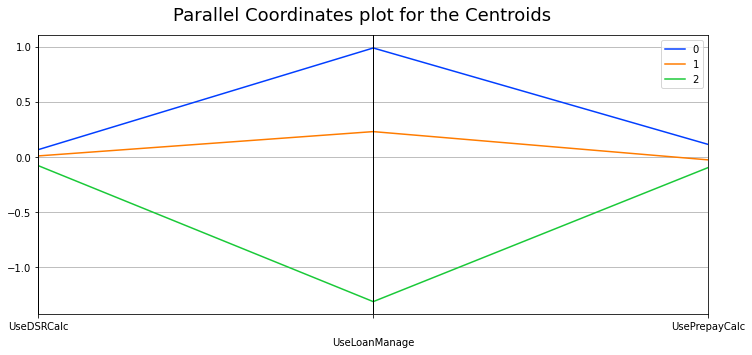

In [ ]:
palette = sns.color_palette("bright", 10)

temp = set_centroid(k_3[1])[['UseDSRCalc', 'UseLoanManage', 'UsePrepayCalc']]
display_parallel_coordinates_centroids(set_centroid(temp), 3)

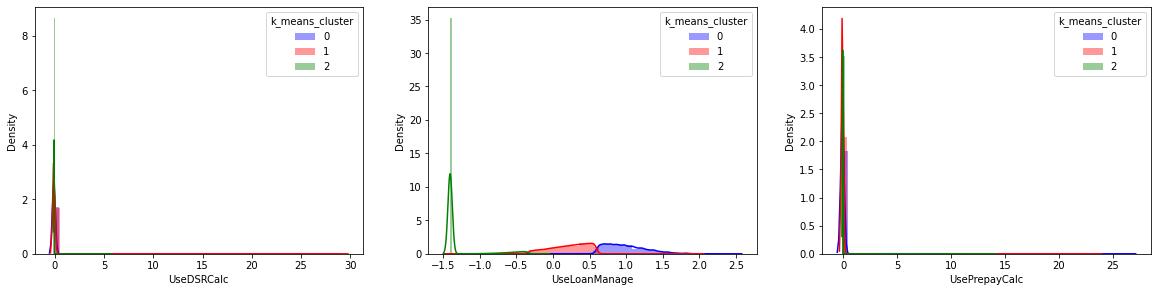

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(2,3,1) 
sns.distplot(k_3[0][k_3[0].k_means_cluster == 0]["UseDSRCalc"], 
             color="blue", label=0)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 1]["UseDSRCalc"], 
             color="red", label=1)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 2]["UseDSRCalc"], 
             color="green", label=2)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,2) 
sns.distplot(k_3[0][k_3[0].k_means_cluster == 0]["UseLoanManage"], 
             color="blue", label=0)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 1]["UseLoanManage"], 
             color="red", label=1)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 2]["UseLoanManage"], 
             color="green", label=2)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,3)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 0]["UsePrepayCalc"], 
             color="blue", label=0)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 1]["UsePrepayCalc"], 
             color="red", label=1)
sns.distplot(k_3[0][k_3[0].k_means_cluster == 2]["UsePrepayCalc"], 
             color="green", label=2)
plt.legend(title="k_means_cluster")

plt.show()

##applied1 - 유저 경제

In [ ]:
df = pd.read_pickle('/content/drive/Shareddrives/빅콘테스트/0_최종코드/클러스터링/applied1_droped')
data = df[['user_id', 'excess_of_existing_loan', 'credit_score', 'yearly_income']]
data['yearly_income'] = data['yearly_income'].apply(lambda x: np.log(x+1))

In [ ]:
df = scaling(data)
print('k=2')
k_2 = clustering(df, 2)
print('k=3')
k_3 = clustering(df, 3)
print('k=4')
k_4 = clustering(df, 4)
print('k=5')
k_5 = clustering(df, 5)
print('k=6')
k_6 = clustering(df, 6)

k=2
k_means_cluster
0    0.447096
1    0.475276
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.464
k=3
k_means_cluster
0    0.476375
1    0.548083
2    0.363416
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.495
k=4
k_means_cluster
0    0.447759
1    0.599879
2    0.353548
3    0.601252
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.555
k=5
k_means_cluster
0    0.461172
1    0.564391
2    0.605616
3    0.592874
4    0.563420
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.586
k=6
k_means_cluster
0    0.617905
1    0.661278
2    0.438213
3    0.456079
4    0.651962
5    0.575525
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.605


In [ ]:
a1user = k_5[0]['k_means_cluster'].reset_index()

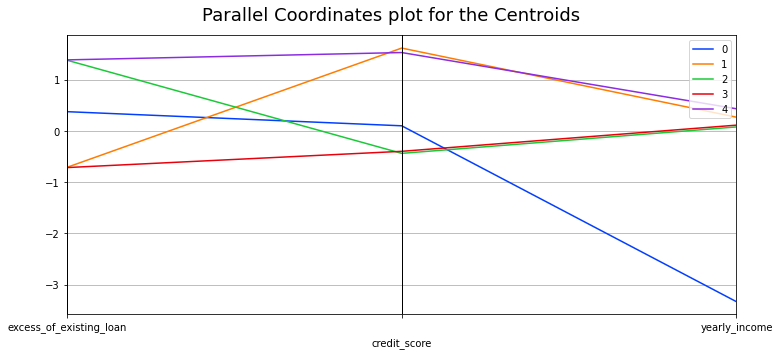

In [ ]:
palette = sns.color_palette("bright", 10)

temp = set_centroid(k_5[1])[['excess_of_existing_loan', 'credit_score', 'yearly_income']]
display_parallel_coordinates_centroids(set_centroid(temp), 5)

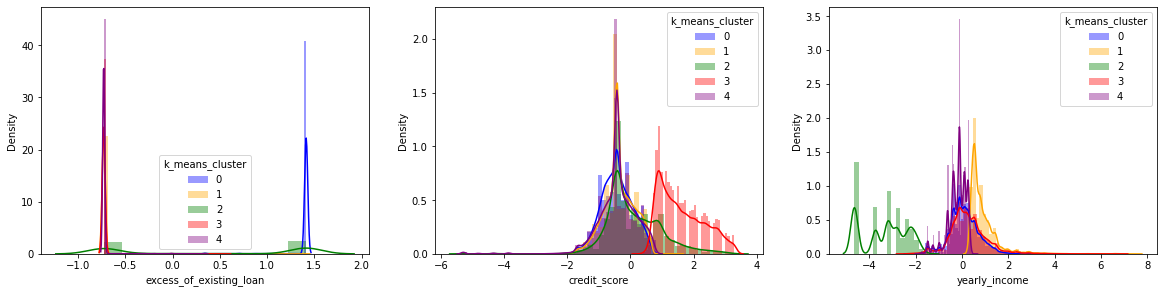

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(2,3,1) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["excess_of_existing_loan"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["excess_of_existing_loan"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["excess_of_existing_loan"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["excess_of_existing_loan"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["excess_of_existing_loan"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,2) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["credit_score"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["credit_score"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["credit_score"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["credit_score"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["credit_score"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["yearly_income"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["yearly_income"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["yearly_income"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["yearly_income"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["yearly_income"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")

plt.show()

## applied0 - 핀다 이용 양상

In [ ]:
data = pd.read_pickle('/content/drive/Shareddrives/빅콘테스트/0_최종코드/클러스터링/applied0_droped')
action = data[['user_id','UseDSRCalc', 'UseLoanManage', 'UsePrepayCalc']]
action = action.set_index('user_id')
scaled_action = action.apply(lambda x: np.log(x*100+1))
scaled_action = scaled_action.reset_index()

In [ ]:
df = scaling(scaled_action)
print('k=2')
k_2 = clustering(df, 2)
print('k=3')
k_3 = clustering(df, 3)
print('k=4')
k_4 = clustering(df, 4)
print('k=5')
k_5 = clustering(df, 5)
print('k=6')
k_6 = clustering(df, 6)

k=2
k_means_cluster
0    0.915876
1    0.136492
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.907
k=3
k_means_cluster
0    0.987015
1    0.779459
2    0.131689
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.878
k=4
k_means_cluster
0    0.984820
1    0.777993
2    0.339578
3    0.620660
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.882
k=5
k_means_cluster
0    0.984200
1    0.778343
2    0.622511
3    0.540732
4    0.470232
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.884
k=6
k_means_cluster
0    0.781561
1    0.984002
2    0.630332
3    0.640906
4    0.499182
5    0.466769
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.885


In [ ]:
a0action = k_5[0]['k_means_cluster'].reset_index()

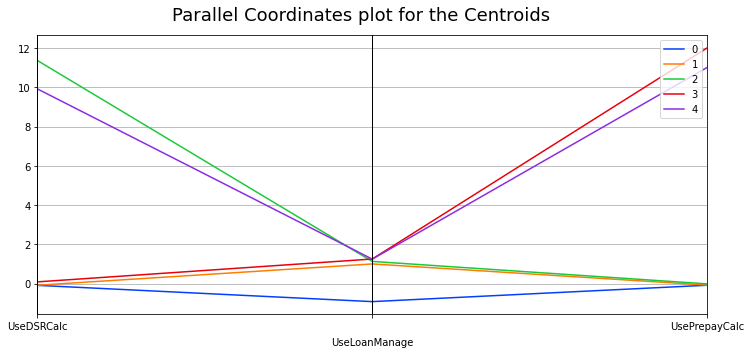

In [ ]:
palette = sns.color_palette("bright", 10)

temp = set_centroid(k_5[1])[['UseDSRCalc', 'UseLoanManage', 'UsePrepayCalc']]
display_parallel_coordinates_centroids(set_centroid(temp), 5)

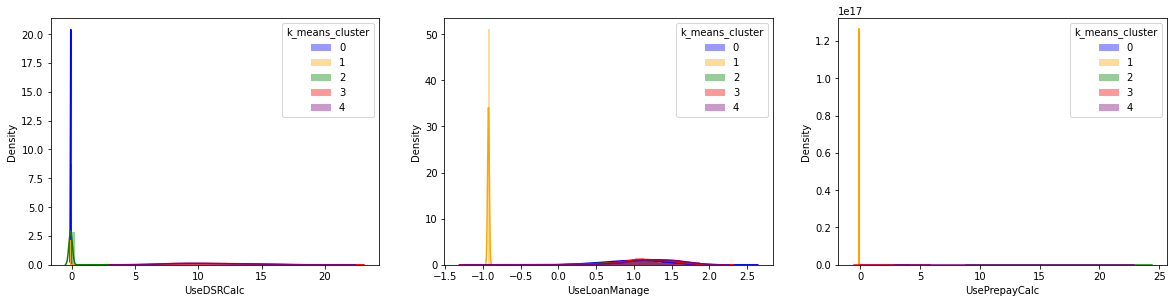

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(2,3,1) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]['UseDSRCalc'], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]['UseDSRCalc'], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]['UseDSRCalc'], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]['UseDSRCalc'], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]['UseDSRCalc'], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,2) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]['UseLoanManage'], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]['UseLoanManage'], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]['UseLoanManage'], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]['UseLoanManage'], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]['UseLoanManage'], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]['UsePrepayCalc'], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]['UsePrepayCalc'], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]['UsePrepayCalc'], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]['UsePrepayCalc'], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]['UsePrepayCalc'], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")

plt.show()

## applied0 - 유저 경제

In [ ]:
df = pd.read_pickle('/content/drive/Shareddrives/빅콘테스트/0_최종코드/클러스터링/applied0_droped')
data = df[['user_id', 'excess_of_existing_loan', 'credit_score', 'yearly_income']]
data['yearly_income'] = data['yearly_income'].apply(lambda x: np.log(x+1))

In [ ]:
df = scaling(data)
print('k=2')
k_2 = clustering(df, 2)
print('k=3')
k_3 = clustering(df, 3)
print('k=4')
k_4 = clustering(df, 4)
print('k=5')
k_5 = clustering(df, 5)
print('k=6')
k_6 = clustering(df, 6)

k=2
k_means_cluster
0    0.435397
1    0.476466
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.464
k=3
k_means_cluster
0    0.615766
1    0.382932
2    0.619195
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.551
k=4
k_means_cluster
0    0.484753
1    0.598834
2    0.555061
3    0.479345
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.548
k=5
k_means_cluster
0    0.489144
1    0.648264
2    0.618867
3    0.641088
4    0.654464
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.634
k=6
k_means_cluster
0    0.676185
1    0.560095
2    0.669215
3    0.407775
4    0.676098
5    0.775038
Name: k_silhouette_coeff, dtype: float64
Average Silhouette Score:0.655


In [ ]:
a0user = k_5[0]['k_means_cluster'].reset_index()

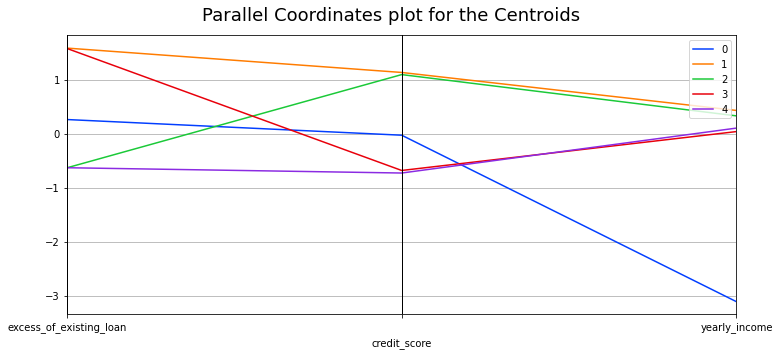

In [ ]:
palette = sns.color_palette("bright", 10)

temp = set_centroid(k_5[1])[['excess_of_existing_loan', 'credit_score', 'yearly_income']]
display_parallel_coordinates_centroids(set_centroid(temp), 5)

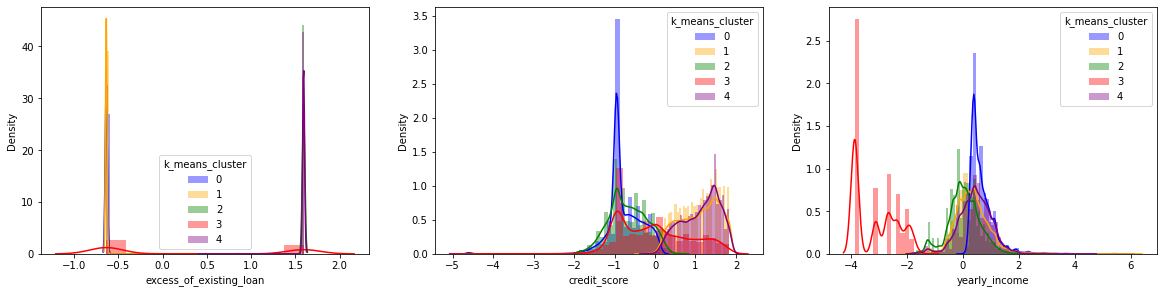

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(2,3,1) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["excess_of_existing_loan"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["excess_of_existing_loan"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["excess_of_existing_loan"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["excess_of_existing_loan"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["excess_of_existing_loan"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,2) 
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["credit_score"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["credit_score"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["credit_score"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["credit_score"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["credit_score"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")


plt.subplot(2,3,3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 0]["yearly_income"], 
             color="blue", label=0)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 1]["yearly_income"], 
             color="orange", label=1)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 2]["yearly_income"], 
             color="green", label=2)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 3]["yearly_income"], 
             color="red", label=3)
sns.distplot(k_5[0][k_5[0].k_means_cluster == 4]["yearly_income"], 
             color="purple", label=4)
plt.legend(title="k_means_cluster")

plt.show()

#최종 결과

In [ ]:
a0action.columns = ['user_id', 'action_cluster']
a1action.columns = ['user_id', 'action_cluster']
a0user.columns = ['user_id', 'user_cluster']
a1user.columns = ['user_id', 'user_cluster']

,user_id,action_cluster
0,9.0,1
1,14.0,1
2,19.0,1
3,33.0,1
4,59.0,0
...,...,...
99105,879659.0,0
99106,879660.0,0
99107,879665.0,0
99108,879688.0,1


In [ ]:
apply0 = pd.merge(a0user, a0action, how = 'left', on = 'user_id')
apply1 = pd.merge(a1user, a1action, how = 'left', on = 'user_id')